

## Intro

___

So graphs are made up of nodes and edges. We're going to build on top of a graph a random dynamical system that's going to move around on it known as a random walk. By doing so and recording each of the steps the random dynamical system takes we will manage to extract samples of the population of nodes in the graph.

Typically if you allow the random walk to move between nodes by selecting the next node uniformly from the set of connections the collection of nodes you end up with in your orbit isn't  a uniform distrubution of the network nodes in general. Instead you get something biased towards nodes with higher connection counts. There is a trick to modifying the nature of the random walk so that it gets a uniform distrubution accross all the network nodes. This is known as the metropolis hastings algorithm which basically chooses the subsequent nodes in the orbit with higher probability if they're less well connected. 

In the case of the small graphs we're going to look at this sampling method isn't really needed becuase you could just choose a random sample from the nodes. This type of technique is useful for sampling networks from which you cannot just draw a sample. In the case of twitter for instance you cannot select a user at random. In order to fix this you could run a metropolis hastings random walk on the network and after a long time you'd get the sample your want. (It would be a very long time. Twitters api rate limits basically make this impossible in reality) 

Suppose you have a collection of states ${s_1,...,s_n}$ these will be the nodes on the graph. Imagine a little chap we'll call a walker whos sat at one of these nodes/states. We're going to denote the probabaility of the walker at $s_i$ moving to $s_j$ as given by $p_{i,j}$. I'm going to use node and state somewhat interchangeably. The difference is just that a node is a specific node in the network whereas I guess a state refers to the state of the dynamical system. So the location of the walker for instance, which would be at a specific node. 

The states/nodes can really be anything, for instance they could encode letters and the probabailties $p_{a, b}$ would be the probabilty for finding the letters 'a' and 'b' next to each other in a sentance.


## imports

---

before we start i'm going to import a tun of stuff. The pairwise function will be useful for turning orbits into pairwise transistions in points. We can then use this to count frequencies of transistions and then approximate probabailities. I'm going to use it to train approximations of transition matrixes for sentances where a sentance is an orbit on a network with letters for nodes. 

In [34]:
from itertools import tee
import random
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
import math

# For generating pairwise elements in a list. [1,2,3,4,5] becomes (1,2), (2,3), (3,4), (4,5)
def pairwise(iterable):
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

# example:
orbit = 'hello'
for s_1, s_2 in pairwise(orbit):
    print(s_1, '->', s_2)

h -> e
e -> l
l -> l
l -> o


I'm going to represent three objects of interest using classes. 

1. The first is a walker class. We're going to use this to generate random walks from the graph. It stores only a single state so for instance perhaps the letter 'l'. 


In [35]:
# For running random walks on the graph
class Walker:
    def __init__(self, state):
        self.state = state



2. The next is called State and represents distrubutions of walkers. So picture each walker as an individual in a population. Suppose for this popultaion 50% of the walker individuals are sat on the letter 'l' then we represent that by setting the dictionary value for 'l' to 0.5. This is a vector representation of how things, in this case our walkers, are distrubuted across the network. Most of the methods i've defined on this class are for visulizing the distrubution or creating specific froms of the distrubution. We'll see more later.


In [36]:
# Abstaction of single state such as in the Walker class to a distrubution of states.
class State:
    def __init__(self, states):
        self.states = {state: 0  for state in states}
        
    def __str__(self):
        string = ''
        count = 0
        print('-------------------------------------------------------------------------------')
        for i, k in self.states.items():
            count = count + 1
            string = string + '{}  :  {:.5f}  |  '.format(i, k)
            if count > 5:
                string = string + '\n'
                count = 0.
        return string
    
    def draw(self):
        objects = self.states.keys()
        y_pos = np.arange(len(objects))
        performance = [val for k, val in self.states.items()]
        plt.bar(y_pos, performance, align='center', alpha=0.5)
        plt.xticks(y_pos, objects)
        plt.ylabel('density')
        plt.title('Word occurence orbit frequency')
        plt.show()
    
    @classmethod
    def from_orbit(cls, orbit):
        instance = cls(orbit)
        for point in orbit:
            instance.states[point] = instance.states.get(point, 0) + 1
        for key, value in instance.states.items():
            instance.states[key] = instance.states[key]/len(orbit) 
        return instance

    @classmethod
    def from_uniform(cls, states):
        instance = cls(states)
        for key, value in instance.states.items():
            instance.states[key] = 1/len(instance.states) 
        return instance

    
    def __sub__(self, other):
        difference = State(self.states.keys())
        for key, _ in difference.states.items():
            difference.states[key] = abs(self.states.get(key, 0) - other.states.get(key, 0))
        return difference
    
    def dist(self, other):
        diff = other - self
        return math.sqrt(sum([v**2 for _, v in diff.states.items()]))


3. The third is transistion Matrix class encodes the probabailiies of transistions in states. In this case we're looking at transistions between letters. This class acts on each of the Walker and State classes via the `__matmul__` method (more bellow). In the case of the Walker class the matrix will randomly update the node/state the walker is at to one of the nodes it is connected to. Where the likely hood of it choosing a particular connected node is proportional to the transistion probability $p_{i,j}$. This class can also acts on the State class. If we're thinking of the State class as a representation of lots of individual Walker classes where a 0.5 value associated to a node/state means that 0.5 percent of the population of walkers are located at that node. The action of the transistion matrix class gives a new distrubution of walkers after each of them have taken a random step. The density picture of a population of walkers is really just a heuristic. What this vector represents best is the probabailities of finding a walker in a specific place. The action of a transistion matrix $M$ on this density vector at time $t$, $v(t)$ is just matrix multiplication. So: $$v_i(t+1) = M_{0,i}v_0(t) + M_{1,i}v_1(t) + ... + M_{n,i}v_n(t)$$ this just tells us that the new density of walkers at the state $i$, is given by the density at each of the states times there transistion probabilities from that state to state $i$ i.e. the value $M_{j,i}v_j(t)$. In vector matrix notation this is: $$v(t)M$$ but don't worry about this for now. I'm hopfully going to come back to evolution of densities later on.

In [37]:

# Going to map between states with this class
class TransitionMatrix:
    def __init__(self, states, data=None):
        self.p = {state: {} for state in states}
        if data is None:
            data = states
        self._count(data)
        self._normalize()

    def _count(self, states):
        for letter_1, letter_2 in pairwise(states):
            self.p[letter_1][letter_2] = self.p[letter_1].get(letter_2, 0) + 1
        
    def _normalize(self):
        for key, val in self.p.items():
            row_total = sum([count for _, count in val.items()])
            for target, count in val.items():
                self.p[key][target] = self.p[key][target]/row_total

        
    def __matmul__(self, other):
        """If applying the transistion matrix class to a Walker class then select the next state at random. 
        If applying to a State class we generate a new distrbution. """

        if isinstance(other, State):
            new_state = State([s for s, _ in other.states.items()])
            for s_1, p in other.states.items():
                sum_p_s2_s1 = 0
                for s_2, P in self.p.items():
                    sum_p_s2_s1 = sum_p_s2_s1 + other.states[s_2]*P.get(s_1, 0)
                new_state.states[s_1] = sum_p_s2_s1 
            return new_state

        if isinstance(other, Walker):
            ps = self.p[other.state]
            choices = [*ps.keys()]
            weights = [*ps.values()]
            choice = random.choices(choices, weights=weights).pop()
            return Walker(choice)
    


The main feature of the above class is the `__matmul__` method. This means if we have an instance `T` of a TransistionMatrix class and an instance `w` of a Walker class we can write:

```py
T@w
```

Then in the `__matmul__(self, other)`, we have `self` as the TransistionMatrix instance and `other` as the Walker. I've set this up to evolve both States and Walkers so the method first checks which the other object is. In our case it's going to be a Walker. `self.p` is a disctionary that encodes the transition probabailities. `self.p[other.state]` is the set of connected nodes and probabailities from `other.state` or the node on which the walker is sitting. 

so we get the probability vector: `self.p[other.state]`, we unpack the states and the probabilities and tehn use pythons builtin random package to choose one at random in propotion to the weight vector. We then return a new Walker in that state. 

__Note__ _you don't need to use `@` theres nothing special about this operator, it would probabaily be more readable to create a method called multiply instead._


## Creating A Transistion Matrix

___

So i'm going to get the transistion matrix associated to the letter pairs in the above introduction. The class essentially counts through each adjacent pair of letters and records the frequencies they occur. It then normalizes these frequencys so that given a state the sum of probabailties for transitions to each other state from that state is 1.

In [38]:
import re

intro = """So graphs are made up of nodes and edges. We're going to build on top of a graph a random dynamical system that's going to move around on it known as a random walk. Doing so and recording each of the steps the random dynamical system takes we will manage to extract samples of the nodes in the graph. Typically if you allow the random walk to move between node by sellecting the next node uniformly from the set of connections you don't get a uniform distrubution of the network nodes. Instead you get something biased towards nodes with higher connection counts. There is a trick to modifying the nature of the random walk so that it gets a uniform distrubution accross all the network nodes this is known as the metropolis hastings algorithm which basically chooses subsequent nodes with higher probability if they're less connected. In the case of the small graphs we're going to look at this sampling method isn't really needed becuase you could just choose a random sample from the nodes. This type of technique is useful for sampling networks from which you can just draw a sample. In the case of twitter for instance you cannot select a user at random this means any sample you draw fromt he twitter network will be biased. In order to fix this you could run a metropolis hastings random walk on the network and after a long time you'd get the sample your want. (It would be a very long time. Twitters api rate limits basically make this impossible in reality) Suppose you have a collection of states ${s_1,...,s_n}$ these will be the nodes on the graph. Imagine a little chap we'll call a walker whos sat at one of these nodes/states. We're going to denote the probabaility of the walker at $s_i$ moving to $s_j$ as given by $p_{i,j}$. The states/nodes can really be anything, for instance they could encode letters and the probabailties $p_{a, b}$ would be the probabilty for finding the letters 'a' and 'b' next to each other in a sentance."""

cleaned_intro = re.sub(r'\W+', '', intro)

T = TransitionMatrix(cleaned_intro)


So now we can see which letters can go to which other letters and how likely they are to do so. We just look at `T.p['u']`.

In [39]:
T.p['u']

{'p': 0.05128205128205128,
 'i': 0.02564102564102564,
 'n': 0.15384615384615385,
 'a': 0.05128205128205128,
 'd': 0.07692307692307693,
 'b': 0.07692307692307693,
 't': 0.05128205128205128,
 'g': 0.02564102564102564,
 'r': 0.05128205128205128,
 'e': 0.05128205128205128,
 'c': 0.10256410256410256,
 'l': 0.15384615384615385,
 's': 0.10256410256410256,
 'h': 0.02564102564102564}

We can verify the sum of these values is 1. The set up here is all done in the `_normalize` and `_count` methods on the TransistionMatrix class

In [40]:
sum([v for _,v in T.p['u'].items()])

1.0

## Sampling orbits

___

So first lets draw a orbit from the state space by iterativly applying a transition matrix to a walker. We're just going it iterativly apply `T@` to `w`.

In [41]:
m = State(cleaned_intro)
T = TransitionMatrix(cleaned_intro)
w = Walker('t')
w.state
orbit = [w]

for i in range(10):
    orbit.append(T@orbit[-1])

print([o.state for o in orbit])

['t', 'l', 'l', 'g', 'r', 'o', 'w', 'n', 't', 'h', 'e']


We can compute the probabaility of a given orbit by multiplying the probabailites of each of the trasnistions. So given an orbit $o=[s_1, s_2, ..., s_n]$ it's liklyhood of occuring is:
$$p(o) = \prod_{i=0}^{n}p(s_i|s_{i-1})$$
where $p(s_i| s_{i-1}) = p_{s_{i-1},s_i}$ is the probability of $s_{i-1}$ going to $s_i$.

In [42]:
p_o = 1
for s_1, s_2 in pairwise(orbit):
    print(s_1.state, ' -> ' ,s_2.state, ' with prob:',T.p[s_1.state][s_2.state])
    p_o = p_o*T.p[s_1.state][s_2.state]

print('--------------------------------')
print('prob of orbit: ', p_o)

t  ->  l  with prob: 0.00684931506849315
l  ->  l  with prob: 0.20833333333333334
l  ->  g  with prob: 0.027777777777777776
g  ->  r  with prob: 0.13157894736842105
r  ->  o  with prob: 0.16
o  ->  w  with prob: 0.028985507246376812
w  ->  n  with prob: 0.05714285714285714
n  ->  t  with prob: 0.11504424778761062
t  ->  h  with prob: 0.3013698630136986
h  ->  e  with prob: 0.5
--------------------------------
prob of orbit:  2.3960031603136377e-11


The outcome is very small which is to be expected given that the number of possible orbits grows large fast.

## Distrubutions

---

Lets quickly rehash the State Class. So the State class represents distrubutions on the set of letters that make up the nodes of the network. 

Suppose we want to draw a representative sample of this network of letters. In this case we're drawing an analogy between twitter and the letters in our network. So a representative sample of the network just means a representative sample of the nodes, in our case letters, (Twitters: users).

This can be represented by a density that's uniform across all the letters. This is representative in that if we took a sample from it the probabaility of us drawing a particular node is the same as drawing any other. These types of samples are important if your trying to talk about the average member of a population.

I've defined a class method that builds this probabaility vector for you (The assumption of metropolis hastings is that this is unreachable, i.e. we cannot sample from this distrubution):

-------------------------------------------------------------------------------
S  :  0.03125  |  o  :  0.03125  |  g  :  0.03125  |  r  :  0.03125  |  a  :  0.03125  |  p  :  0.03125  |  
h  :  0.03125  |  s  :  0.03125  |  e  :  0.03125  |  m  :  0.03125  |  d  :  0.03125  |  u  :  0.03125  |  
f  :  0.03125  |  n  :  0.03125  |  W  :  0.03125  |  i  :  0.03125  |  t  :  0.03125  |  b  :  0.03125  |  
l  :  0.03125  |  y  :  0.03125  |  c  :  0.03125  |  v  :  0.03125  |  k  :  0.03125  |  w  :  0.03125  |  
D  :  0.03125  |  x  :  0.03125  |  T  :  0.03125  |  I  :  0.03125  |  q  :  0.03125  |  j  :  0.03125  |  
_  :  0.03125  |  1  :  0.03125  |  


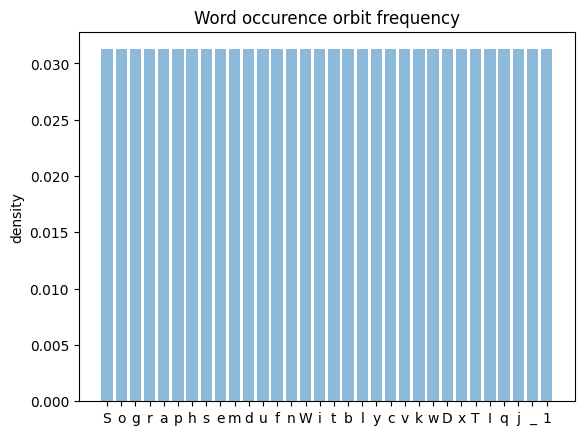

In [43]:
m = State(cleaned_intro)
uniform = State.from_uniform(m.states.keys())
print(uniform)
uniform.draw()

Lets now see what the distrubution of letters looks like when we take a sample from the network by running a Walker on the network for a long time and storing each of the nodes that it arrives at along it's path.

-------------------------------------------------------------------------------
t  :  0.09498  |  h  :  0.04939  |  e  :  0.11258  |  a  :  0.07998  |  s  :  0.06319  |  x  :  0.00280  |  
l  :  0.04079  |  d  :  0.03679  |  b  :  0.01900  |  y  :  0.02300  |  w  :  0.02120  |  o  :  0.09098  |  
g  :  0.02400  |  n  :  0.07558  |  i  :  0.05759  |  r  :  0.04859  |  k  :  0.01180  |  v  :  0.00600  |  
m  :  0.02979  |  p  :  0.02140  |  u  :  0.02380  |  I  :  0.00460  |  c  :  0.03039  |  _  :  0.00320  |  
j  :  0.00240  |  T  :  0.00380  |  f  :  0.01940  |  D  :  0.00040  |  W  :  0.00060  |  S  :  0.00060  |  
q  :  0.00140  |  


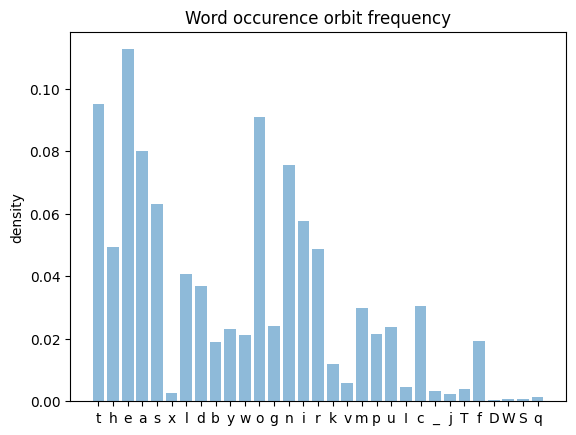

In [44]:
m = State(cleaned_intro)
T = TransitionMatrix(cleaned_intro)
w = Walker('t')
w.state
orbit = [w]

for i in range(5000):
    orbit.append(T@orbit[-1])

orbit_dist = State.from_orbit([o.state for o in orbit])
print(orbit_dist)
orbit_dist.draw()

So this cleary hasn't converged to a representative sample of the network as it's hevily biased towards certain nodes. To talk about convergence more clearly we need to difine a metric by which to gauge how similar two distrubutions are. 

## Similarity of Distrubutions:

___

To get this we just subract the two vectors from each other, sum the square of the differences and take the square root of the sum. 

$$dist(p_1, p_2) = \sqrt{\sum_{i=0}^{N}(p_1[i] - p_2[i])^2}$$

I've added a dist method to the State class that computes this quantity. So for two equal distrubutions we get: 

In [45]:
uniform.dist(uniform)

0.0

and for two unequal distrubutions we have a value greater than zero:

In [46]:
orbit_dist.dist(uniform)

0.17698646223343223

this gives us a method for examining convergence of orbits and allows us to numerically answer:

    - Is it the case that two different orbits are converging to the same distrubution. 
    - And how does the orbit distrubution converge or not converge w.r.t. the uniform distrubution  
    
We can test this. The following graphs show how the orbit distrubutions of two random walks converge to each other but neither converge to the uniform distrubution:

**Note**: _This is not a fast way of doing this, but it'll do_

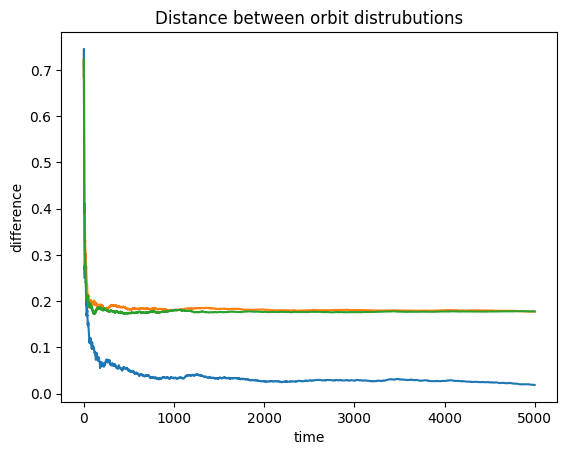

In [47]:
T = TransitionMatrix(cleaned_intro)
orbit_1 = [Walker('t')]
orbit_2 = [Walker('o')]
differences_1 = []
differences_2 = []
differences_3 = []

for i in range(5000):
    orbit_1.append(T@orbit_1[-1])
    orbit_2.append(T@orbit_2[-1])
    orbit_dist_1 = State.from_orbit([o.state for o in orbit_1])
    orbit_dist_2 = State.from_orbit([o.state for o in orbit_2])
    differences_1.append(orbit_dist_1.dist(orbit_dist_2))
    differences_2.append(orbit_dist_1.dist(uniform))
    differences_3.append(orbit_dist_2.dist(uniform))
    
plt.plot(differences_1)
plt.plot(differences_2)
plt.plot(differences_3)
plt.title('Distance between orbit distrubutions')
plt.ylabel('difference')
plt.xlabel('time')
plt.show()


Each line in the graph above donotes the distances between the disrubutions of orbit 1, orbit 2 and the uniform distrubution for each step in the each orbit. Not the uniform distrubution is fixed as we don't evolve it via the transition matrix. 

So above we're runing two orbits from different intial points. 't' and 'o'. These orbits converge towards each other as demonstrated by the line that slopes down towards 0. Both of these orbits however don't converge to the uniform distrubution which is represented by the two lines that plato around 0.2. In the next notebook i'm going to show how we can change the random walk to ensure that the orbit does converge to the uniform density.